# <center> Reconnaissance visuelle 

### 1. Préparation du dataset pour vision

On choisit d'utiliser le dataset avec les transformations pertinentes appliquées après exploration des données. Notamment 4 styles avec un nombre insuffisant d'image ont été supprimés pour avoir des classes équilibrées lors de l'apprentissage dans la partie Deep Learning.

In [32]:
import sys
from pathlib import Path

# Pour que notre archi fonctionne avec google colab 
    
!git clone https://github.com/julietteabalain-cloud/Reconnaissance-de-mouvement-artistique.git
!cd /content/Reconnaissance-de-mouvement-artistique && git pull
%cd /content/Reconnaissance-de-mouvement-artistique 
import sys
sys.path.append(".")  # pour que src/ soit importable

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

fatal: destination path 'Reconnaissance-de-mouvement-artistique' already exists and is not an empty directory.
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 6 (delta 5), reused 6 (delta 5), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 4.94 KiB | 24.00 KiB/s, done.
From https://github.com/julietteabalain-cloud/Reconnaissance-de-mouvement-artistique
   f5004b9..3aef808  main       -> origin/main
Updating f5004b9..3aef808
Fast-forward
 notebooks/2_RV_Vision_Classique.ipynb | 2525 +++++++++++++++++++++------------
 src/vision_features_extract.py        |   10 +-
 2 files changed, 1653 insertions(+), 882 deletions(-)
/content/Reconnaissance-de-mouvement-artistique


In [33]:
import torch
from src.dataset import load_df_train_test_val, load_df, load_image
from src.preprocessing import clean_dataset

#pour avoir acces au GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [34]:
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path

PROJECT_ROOT = Path("/content/deepl-projet")
DATA_ROOT = Path("/content/drive/MyDrive/DeepLearning/WikiArt_Subset")


df_test, df_train, df_val = load_df_train_test_val(DATA_ROOT)
df_full = load_df(DATA_ROOT)

df, df_train, df_val, df_test = clean_dataset(df_full, df_train, df_val, df_test)

print(f"Vérification des splits :")
print(f"- Train: {df_train['split'].unique()} ({len(df_train)} images)")
print(f"- Val  : {df_val['split'].unique()} ({len(df_val)} images)")
print(f"- Test : {df_test['split'].unique()} ({len(df_test)} images)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Vérification des splits :
- Train: ['train'] (6449 images)
- Val  : ['val'] (1373 images)
- Test : ['test'] (1378 images)


/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["style_encoded"] = le.fit_transform(df_train["style"])
/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["style_encoded"]   = le.transform(df_val["style"])
/content/Reconnaissance-de-mouvement-artistique/src/preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [35]:
import src.preprocessing as preprocessing_module
import src.vision_features_extract as vision_features_extract_module

from importlib import reload

vision_features_extract_module = reload(vision_features_extract_module)

### 2. Extraction des features



#### 2.1 Contour et gradients 



Dans cette section, nous étudions les contours présents dans les œuvres du dataset WikiArt.
L’objectif est de déterminer si certains styles artistiques se distinguent par des contours
plus nets ou plus flous, à l’aide d’un détecteur de Sobel et d’analyses statistiques des gradients.

L'intuition serait que les styles nets (Cubisme, Pop Art, Precisionism) auraient des gradients forts, orientations bien définies, forte magnitude tandis que les styles flous (Impressionism, Romanticism, Baroque) auraient des gradients plus faibles, orientations dispersées, faible magnitude.

##### 2.1.1 Sous Dataset

Nous sélectionnons quelques styles contrastés afin de faciliter l’analyse qualitative
et quantitative des contours.


In [10]:
selected_styles = ["Impressionism", "Cubism", "Baroque", "Romanticism", "Pop_Art"]

df_subset = df[df["style_name"].isin(selected_styles)]
print(df_subset["style_name"].value_counts())


style_name
Pop_Art          400
Cubism           400
Impressionism    400
Baroque          400
Romanticism      400
Name: count, dtype: int64


##### 2.1.2 Sobel

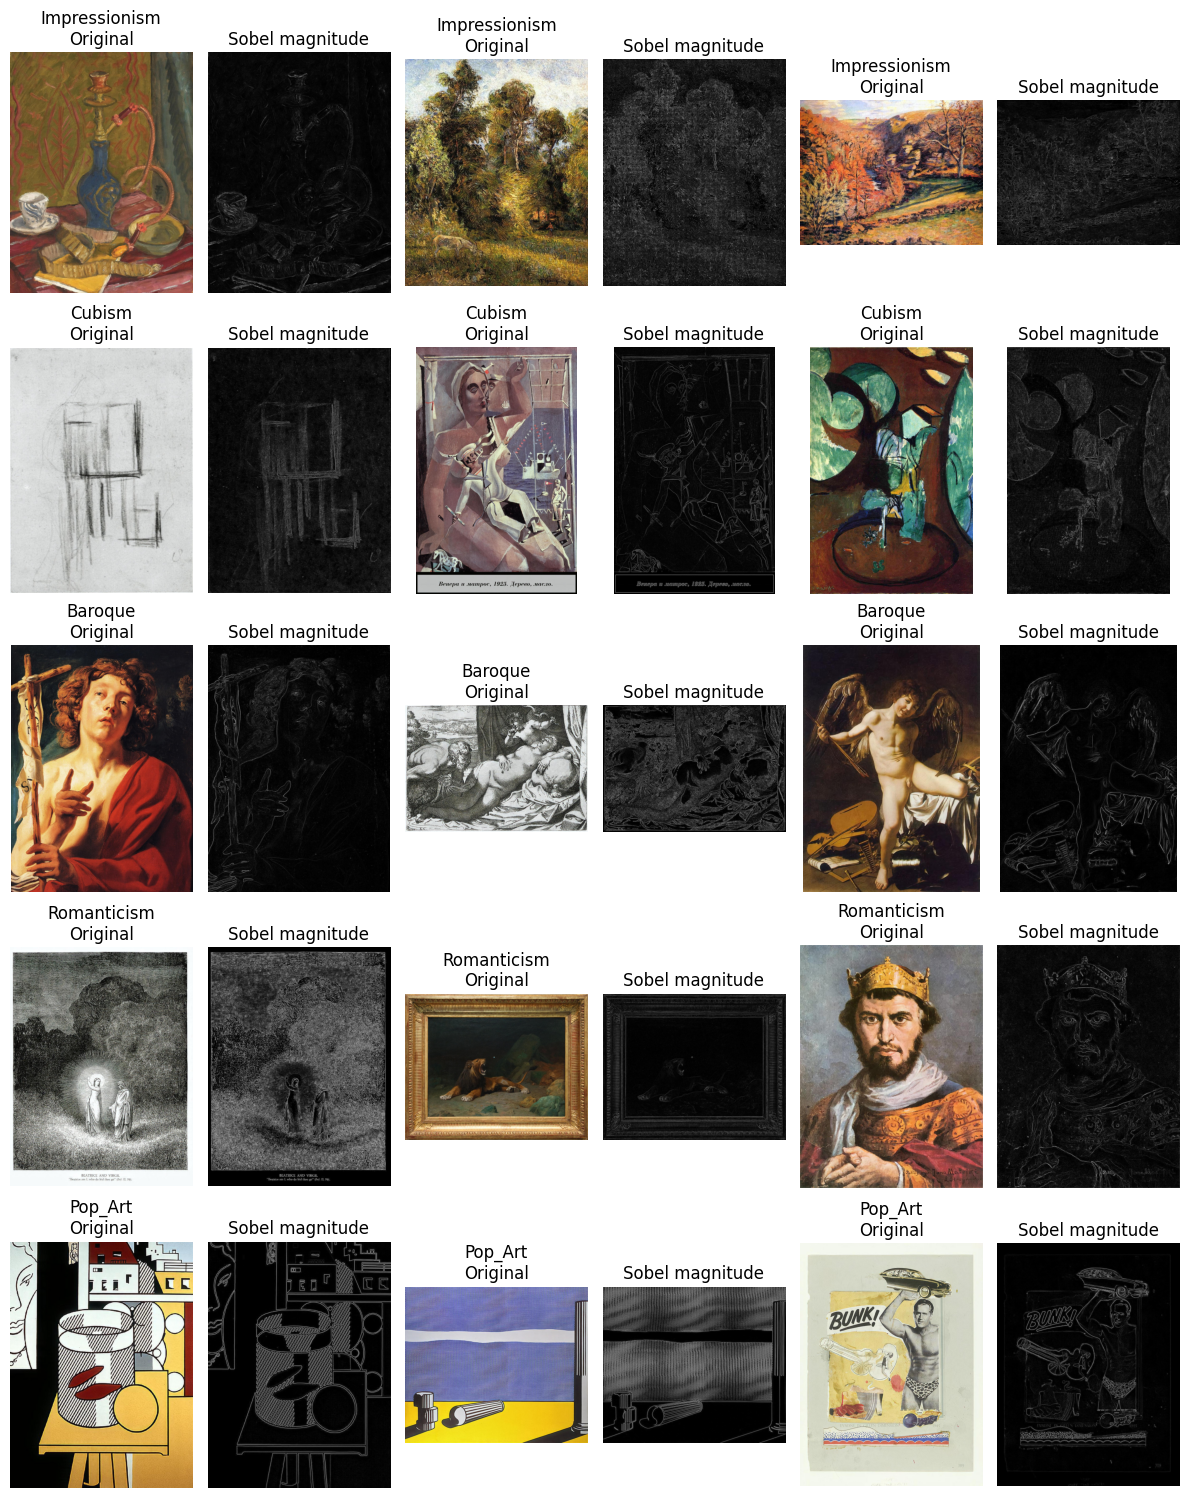

In [11]:
vision_features_extract_module.plot_sobel_examples(
    df_subset,
    load_image,
    DATA_ROOT,
    styles=selected_styles,
    n_images_per_style=3
)


On observe que certains styles présentent des contours plus nets et structurés
(PopArt, Cubism), tandis que d’autres styles comme l’Impressionnisme montrent
des transitions plus douces et moins de contours marqués.


##### 2.1.3 Extraction des histogrammes de gradient

Nous calculons maintenant, pour chaque image, des histogrammes de magnitude
et d’orientation des gradients afin de quantifier la structure des contours.


In [7]:
style_gradients = vision_features_extract_module.aggregate_histograms_by_style(
    df,
    load_image,
    DATA_ROOT,
    max_images_per_style=150
)


  0%|          | 15/9200 [00:16<2:50:15,  1.11s/it]


KeyboardInterrupt: 

##### 2.1.4 Histogrammes moyens par styles

On affiche les histogrammes moyens par style de magnitude puis d'orientation :

/content/Reconnaissance-de-mouvement-artistique/src/vision_features_extract.py:190: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


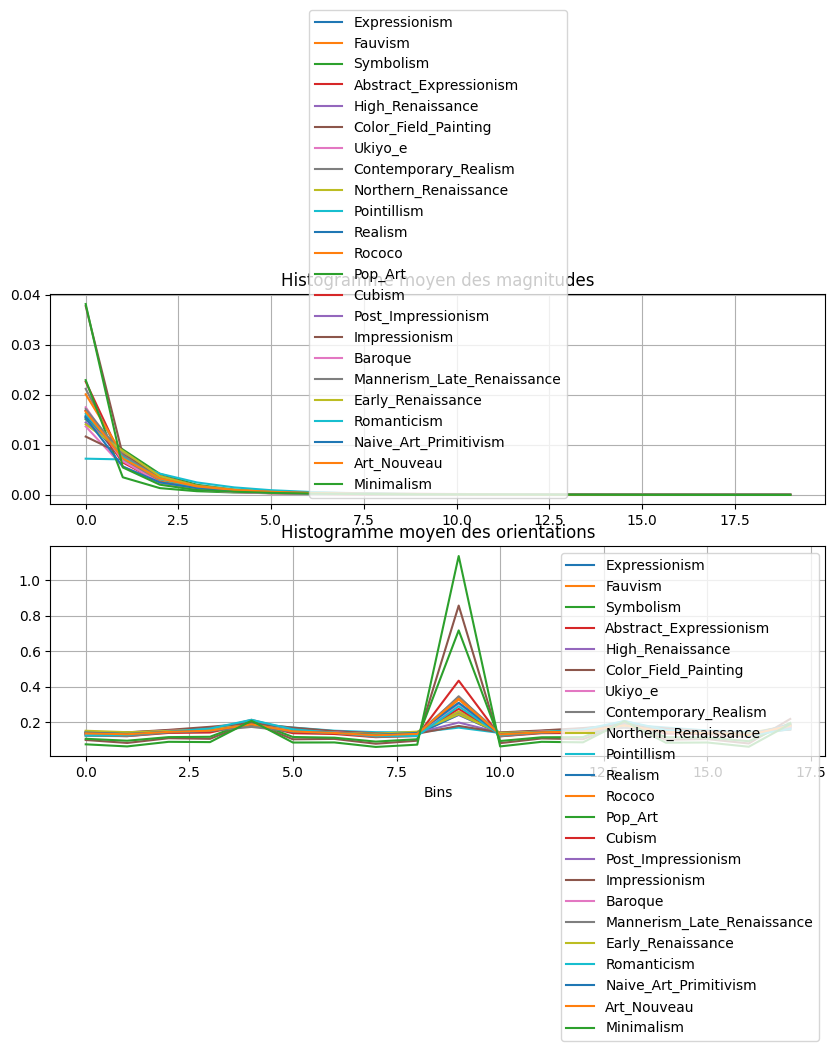

In [10]:
vision_features_extract_module.plot_mean_gradient_histograms(
    style_gradients,
    df["style_name"].unique(),
    )


On observe seulement pour Pop Art une démarcation dans l'histogramme des orientations du gradient. Le reste des styles ne sont pas particulièrement reconnaissables via cette information. Ce n'est pas suffisant.

On va essayer de claculer un score par style pour determiner si c'est uns tyle aux contour fort ou fiable

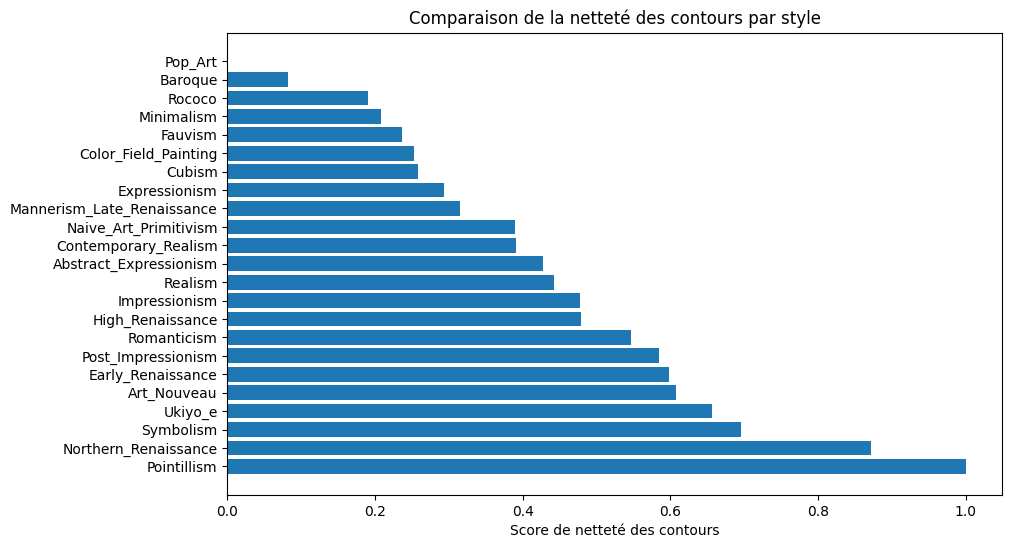

In [11]:
vision_features_extract_module.compute_scores(df["style_name"].unique(), style_gradients)

Impressionnisme = score élevé : beaucoup de coups de pinceau, gradients forts, mais diffus spatialement

Pop Art = score faible : aplats de couleur, grandes zones uniformes, peu de gradient

L’analyse des gradients de Sobel montre que les styles artistiques se
distinguent nettement par l’intensité moyenne de leurs transitions
locales.
Certains styles, comme l’impressionnisme ou l’expressionnisme,
présentent une forte proportion de gradients élevés, traduisant une
richesse de variations locales et de coups de pinceau visibles.
À l’inverse, des styles comme le Pop Art ou le Minimalisme reposent
davantage sur de larges aplats de couleur, générant moins de gradients
de forte amplitude.

#### 2.2 Descripteurs globaux

Nous utiliserons des descripteurs globaux pour
compl´eter nos features. Nous utiliserons le descripteur
HOG qui capturera la structure directionnelle locale (tech-
nique picturale) ainsi qu’un descripteur couleur dans les
espaces.


Pour chaque image on extrait HOG : Histogram of Oriented Gradient.
Puis on extrait des descripteurs de couleur dans les espaces Lab et HSV. 
Enfin on normalise et combine toutes ses features en un vecteur par image. 

In [5]:
x,y, filenames = vision_features_extract_module.extract_features_dataset(df, load_image, DATA_ROOT)

  1%|          | 98/9200 [00:41<1:03:36,  2.38it/s]


KeyboardInterrupt: 

#### 2.3 Distances et caractéristiques des styles

A partir des descripteurs locaux, on étudie les caractéristique de chaque style ce qui permettrait de les différencier, et également leurs distances entre eux selon différents descripteurs.

D'abord pour ce qui est lié aux caractéristiques HOG et couleur en effectuant un calcul de distance entre les cractéristiques moyennes de chaque style  :  

In [ ]:
dist_df = vision_features_extract_module.visualize_style_distances(x,y)
vision_features_extract_module.heatmap_style_distances(dist_df)
# intéressant de comparer cette matrice a celle des distances avec les genres 

Ensuite en applicant PCA pour identifier des regroupement de styles :

In [ ]:
vision_features_extract_module.pca_style_features(x,y)

On étudie les palettes de couleurs des styles :

In [ ]:
palette_impressionisme = vision_features_extract_module.compute_style_palette(df_train, "Pop_Art",load_image, DATA_ROOT)
palette_cubisme = vision_features_extract_module.compute_style_palette(df_train, "Cubism",load_image, DATA_ROOT)


Computing palette for style: Pop_Art


100%|██████████| 276/276 [00:08<00:00, 30.76it/s]


Computing palette for style: Cubism


100%|██████████| 277/277 [01:45<00:00,  2.61it/s]


AttributeError: module 'src.vision_features_extract' has no attribute 'display_palettes'

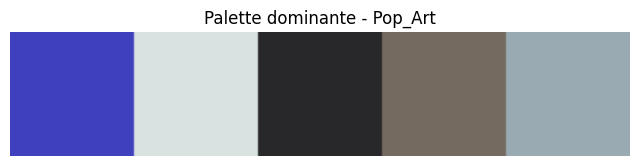

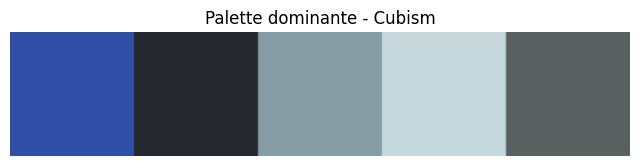

In [37]:
vision_features_extract_module.display_palette(palette_impressionisme, "Pop_Art")
vision_features_extract_module.display_palette(palette_cubisme, "Cubism")

100%|██████████| 200/200 [01:17<00:00,  2.57it/s]


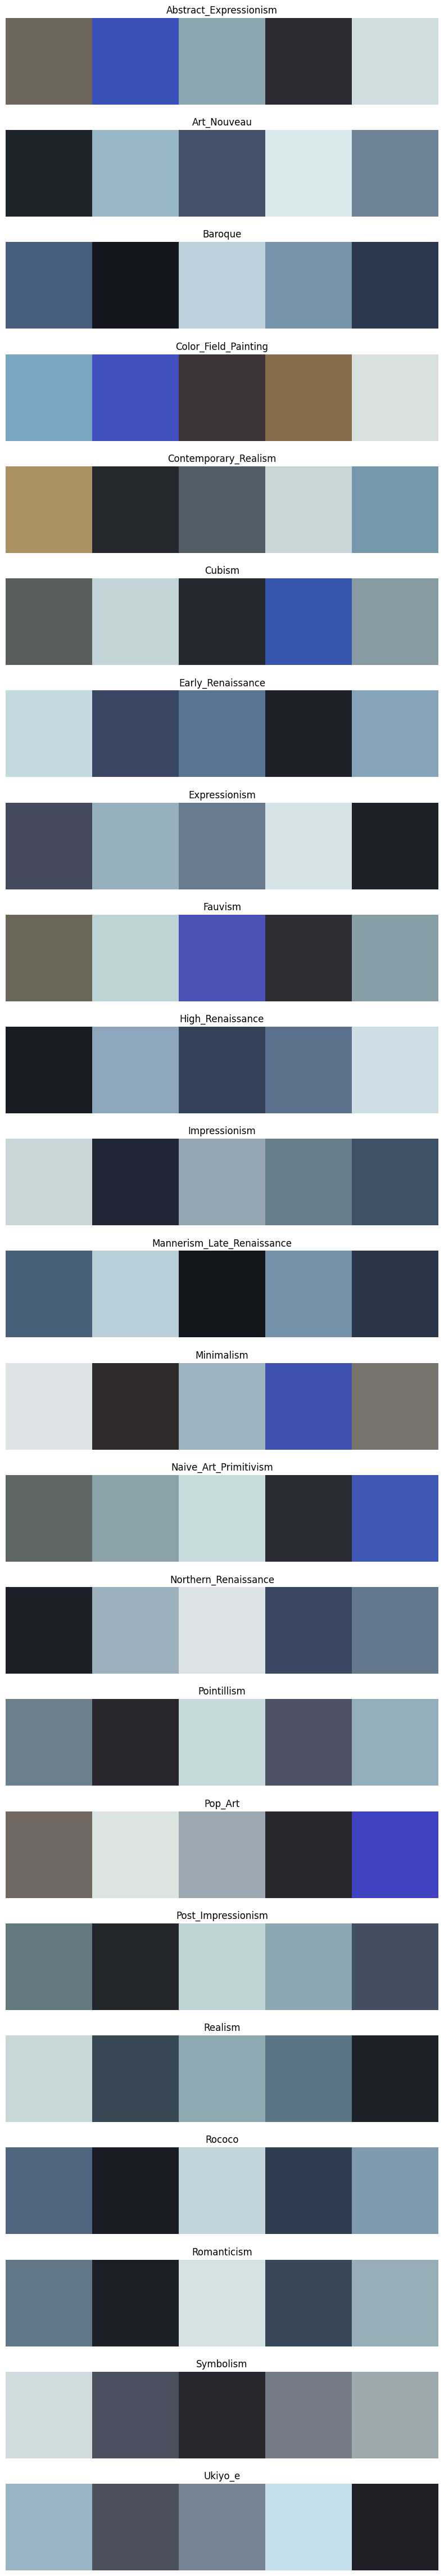

{'Abstract_Expressionism': array([[110, 101,  93],
        [ 58,  80, 185],
        [140, 167, 176],
        [ 45,  44,  51],
        [209, 222, 223]], dtype=uint8),
 'Art_Nouveau': array([[ 30,  36,  43],
        [153, 184, 199],
        [ 69,  83, 106],
        [215, 232, 236],
        [109, 131, 149]], dtype=uint8),
 'Baroque': array([[ 71,  94, 125],
        [ 20,  23,  30],
        [188, 208, 218],
        [117, 149, 172],
        [ 43,  55,  77]], dtype=uint8),
 'Color_Field_Painting': array([[120, 166, 192],
        [ 65,  80, 190],
        [ 60,  50,  56],
        [135, 109,  75],
        [216, 224, 222]], dtype=uint8),
 'Contemporary_Realism': array([[172, 145,  99],
        [ 37,  41,  45],
        [ 82,  92, 100],
        [201, 214, 215],
        [117, 151, 171]], dtype=uint8),
 'Cubism': array([[ 87,  94,  92],
        [195, 212, 216],
        [ 37,  40,  46],
        [ 53,  86, 171],
        [136, 155, 162]], dtype=uint8),
 'Early_Renaissance': array([[197, 217, 225],
    

In [38]:
vision_features_extract_module.compute_and_display_all_style_palettes(df_train, load_image, DATA_ROOT)

On étudie les caractéristiques HSV :

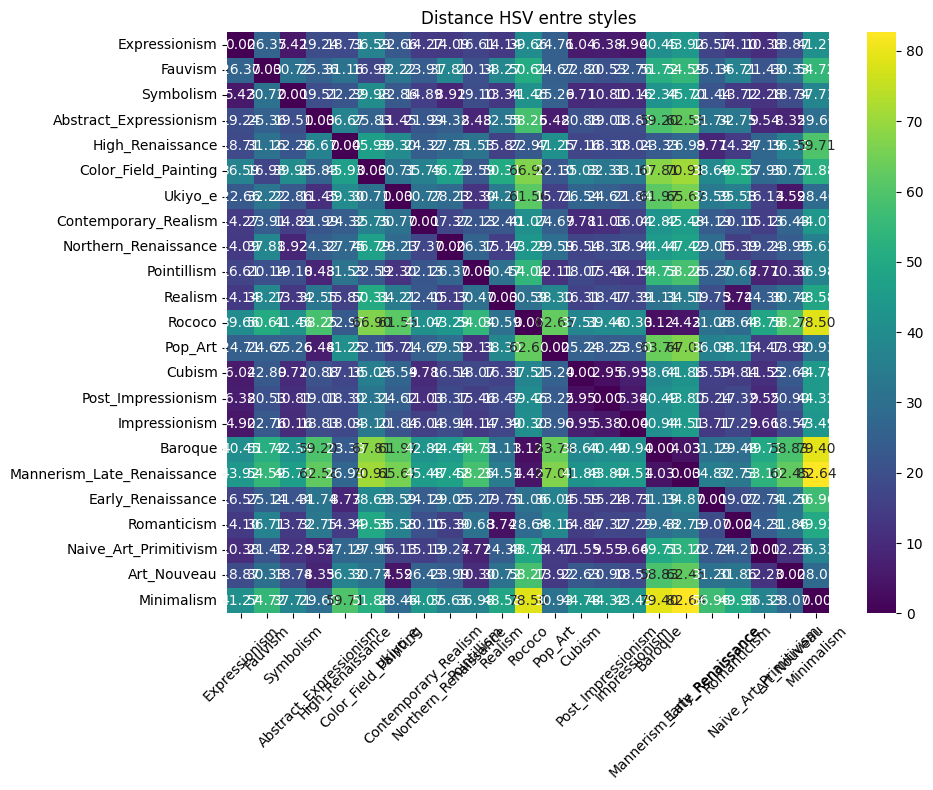

array([[ 0.        , 26.36512832,  5.42473608, 19.2389167 , 18.70855344,
        36.58772643, 22.66348334, 14.26803558, 14.08841384, 16.60701298,
        14.14134656, 39.66007694, 24.70752414,  6.03595616,  6.38315654,
         4.89988595, 40.44625665, 43.9220572 , 16.57209547, 14.09753415,
        10.38315623, 18.86630932, 41.26734081],
       [26.36512832,  0.        , 30.71816361, 25.35785566, 31.16433399,
        16.98288483, 32.21725105, 23.90833617, 37.81023369, 20.13730735,
        38.26851125, 50.60567685, 24.66568236, 22.80010004, 20.53485281,
        22.75827834, 51.71675332, 54.59127712, 25.13813272, 36.7139042 ,
        21.42627363, 30.3261814 , 54.72358864],
       [ 5.42473608, 30.71816361,  0.        , 19.51119558, 22.2235319 ,
        39.98373439, 22.85723847, 14.89207976,  8.91996755, 19.09997042,
        13.33681541, 41.46391077, 25.26350267,  9.70538049, 10.80598289,
        10.15661363, 42.34224309, 45.70223364, 21.44133145, 13.7230757 ,
        12.28196459, 18.7415

In [39]:
style_hsv_vectors = vision_features_extract_module.compute_hsv_stats_all_styles(df, load_image, DATA_ROOT)
vision_features_extract_module.plot_style_distance_heatmap(style_hsv_vectors)

### 3. Extraction des features en CSV

#### 3.1 StandardScaler + PCA

Etant donné la grande taille des vecteurs features pour chaque image (+14000), on décide d'utiliser standardscaler puis d'appliquer PCA pour réduire la dimension du vecteur feature tout en conservant les informations pertinentes.

In [40]:
X_train, y_train, filenames_train = vision_features_extract_module.extract_features_dataset(df_train, load_image, DATA_ROOT)
X_val,   y_val, filenames_val   = vision_features_extract_module.extract_features_dataset(df_val,   load_image, DATA_ROOT)
X_test,  y_test, filenames_test  = vision_features_extract_module.extract_features_dataset(df_test,  load_image, DATA_ROOT)

100%|██████████| 1378/1378 [01:38<00:00, 13.97it/s]


In [41]:
result = vision_features_extract_module.apply_block_pca_for_model(X_train, X_val, X_test)

X_train_pca = result["X_train"]
X_val_pca   = result["X_val"]
X_test_pca  = result["X_test"]


Variance HOG : 0.5507005736421066
Variance HSV : 0.3861310915022856
Variance LAB : 0.527798452523752


In [42]:
import pandas as pd


df_train_pca = vision_features_extract_module.build_pca_dataframe(X_train_pca, df_train, "train")
df_val_pca   = vision_features_extract_module.build_pca_dataframe(X_val_pca, df_val, "val")
df_test_pca  = vision_features_extract_module.build_pca_dataframe(X_test_pca, df_test, "test")

df_all_pca = pd.concat([df_train_pca, df_val_pca, df_test_pca])



#### 3.2 Extraction en CSV

In [43]:
df_all_pca.to_csv("/content/drive/MyDrive/dataset_vision_features.csv", index=False)
